In [36]:
# imports 
import numpy as np
import requests
import pandas as pd
import hashlib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm

In [2]:
# data collection & acquisition 

# Chicago food inspection dataset acquisition
# access data via API and verify integrity with SHA-256

import requests
import pandas as pd
import hashlib
from pathlib import Path

OUTPUT_DIR = Path("data/raw")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
# SODA2 version, does not require authentication
API_ENDPOINT = "https://data.cityofchicago.org/resource/4ijn-s7e5.json"

all_records = []
limit = 50000  
offset = 0

while True:
    params = {
        "$limit": limit,
        "$offset": offset,
        "$order": "inspection_date DESC"
    }
    print(f"Fetching records {offset} to {offset + limit}...")
    resp = requests.get(API_ENDPOINT, params=params)
    resp.raise_for_status()
    payload = resp.json()
    
    if len(payload) == 0:
        break
    
    all_records.extend(payload)
    print(f"  Retrieved {len(payload)} records (Total so far: {len(all_records)})")

    if len(payload) < limit:
        break
    
    offset += limit
print(f"\nSuccessfully fetched {len(all_records)} total records")

chicago_food_inspection = pd.json_normalize(all_records)
chicago_food_inspection.head()

csv_filename = OUTPUT_DIR / "food_inspections.csv"
chicago_food_inspection.to_csv(csv_filename, index=False)

# calculate SHA-256 checksum
with open(csv_filename, "rb") as f:
    sha = hashlib.sha256(f.read()).hexdigest()

sha_filename = OUTPUT_DIR / "food_inspections.sha256"
with open(sha_filename, "w", encoding="utf-8") as f:
    f.write(sha)  

# Verify the checksum was saved correctly
with open(sha_filename, "r", encoding="utf-8") as f:
    saved_checksum = f.read()

Fetching records 0 to 50000...
  Retrieved 50000 records (Total so far: 50000)
Fetching records 50000 to 100000...
  Retrieved 50000 records (Total so far: 100000)
Fetching records 100000 to 150000...
  Retrieved 50000 records (Total so far: 150000)
Fetching records 150000 to 200000...
  Retrieved 50000 records (Total so far: 200000)
Fetching records 200000 to 250000...
  Retrieved 50000 records (Total so far: 250000)
Fetching records 250000 to 300000...
  Retrieved 50000 records (Total so far: 300000)
Fetching records 300000 to 350000...
  Retrieved 1259 records (Total so far: 301259)

Successfully fetched 301259 total records


In [3]:
chicago_food_inspection.head()

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location.latitude,location.longitude,location.human_address
0,2628049,BRO-N-LAWS BAR-B-Q LLC,BRO-N-LAWS BAR-B-Q,2442895,Restaurant,Risk 1 (High),3820 W CHICAGO AVE,CHICAGO,IL,60651,2025-12-04T00:00:00.000,Complaint,Fail,21. PROPER HOT HOLDING TEMPERATURES - Comments...,41.895512999951805,-87.72216981512152,41.895512999951805,-87.72216981512152,"{""address"": """", ""city"": """", ""state"": """", ""zip""..."
1,2628072,CMM FOOD SERVICES,CMM FOOD SERVICES (WRIGHT COLLEGE CAFETERIA),2718677,Restaurant,Risk 1 (High),4300 N NARRAGANSETT AVE,CHICAGO,IL,60634,2025-12-04T00:00:00.000,Canvass Re-Inspection,Pass,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,41.958548345644644,-87.78691898876937,41.958548345644644,-87.78691898876937,"{""address"": """", ""city"": """", ""state"": """", ""zip""..."
2,2628012,TACO NIETOS,TACO NIETOS,2069782,Restaurant,Risk 1 (High),2863 E 95TH ST,CHICAGO,IL,60617,2025-12-04T00:00:00.000,Canvass,Pass,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,41.722619985023755,-87.55407800189569,41.722619985023755,-87.55407800189569,"{""address"": """", ""city"": """", ""state"": """", ""zip""..."
3,2628077,ROKIA HOME OF AFRICA LLC,ROKIA HOME OF AFRICA LLC,3060226,NaN,Risk 1 (High),9707 S HALSTED ST,CHICAGO,IL,60628,2025-12-04T00:00:00.000,License,Not Ready,NaN,41.717488411289914,-87.64295719210287,41.717488411289914,-87.64295719210287,"{""address"": """", ""city"": """", ""state"": """", ""zip""..."
4,2628038,THE WATERHOLE LOUNGE,THE WATERHOLE LOUNGE,81970,Restaurant,Risk 2 (Medium),1400 S WESTERN AVE,CHICAGO,IL,60608,2025-12-04T00:00:00.000,Canvass,Pass,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.862940665238334,-87.68608143770022,41.862940665238334,-87.68608143770022,"{""address"": """", ""city"": """", ""state"": """", ""zip""..."


In [4]:
# Zillow Home Value Index dataset acquisition
# directly download the csv file 
# data available through 2025-09-30
csv_url = "https://files.zillowstatic.com/research/public_csvs/zhvi/Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv?t=1762826225"
response = requests.get(csv_url)

csv_filename = OUTPUT_DIR / "zhvi.csv"
with open(csv_filename, "wb") as f:
    f.write(response.content)
zhvi = pd.read_csv(csv_filename)

with open(csv_filename, "rb") as f:
    sha = hashlib.sha256(f.read()).hexdigest()

sha_filename = OUTPUT_DIR / "zhvi.sha256"
with open(sha_filename, "w", encoding="utf-8") as f:
    f.write(sha)

In [5]:
zhvi.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2025-01-31,2025-02-28,2025-03-31,2025-04-30,2025-05-31,2025-06-30,2025-07-31,2025-08-31,2025-09-30,2025-10-31
0,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,207990.862896,...,496241.955346,495923.501749,495027.233843,493256.614962,491089.575909,488525.475785,486477.885587,485372.312103,485572.025450,486313.753787
1,61148,2,8701,zip,NJ,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,115428.100095,...,539389.412910,541328.620266,543641.012632,546961.018012,549808.083062,552401.074246,554231.272949,555507.245194,558124.481843,563140.887500
2,91940,3,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,103617.439109,...,278857.581088,278234.565344,277403.626819,276446.232480,275643.203948,274644.617583,273705.009498,272771.088086,271993.355984,271254.566351
3,62080,4,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,172177.874323,...,526608.289830,526478.270302,526136.430970,526024.534098,526413.194506,528462.622083,531191.375180,532845.799332,534074.275678,535093.606817
4,91733,5,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,103084.537334,...,274553.215409,274148.943029,273286.424549,272241.767228,271344.301432,270338.034427,269421.435742,268541.858499,267660.543449,266806.718546


# Data Acquisition Documentation

## Overview
This document provides detailed instructions for acquiring the two datasets used in this project. Each dataset uses a different acquisition method to demonstrate diverse data collection approaches:

1. **Chicago Food Inspections**: API access (Socrata SODA API)
2. **Zillow Home Value Index (ZHVI)**: Direct CSV download

Both datasets include SHA-256 checksums for integrity verification and reproducibility.


Or let Python create it automatically (included in notebooks).

---

## Dataset 1: Chicago Food Inspections

### Source Information
- **Provider**: City of Chicago Data Portal
- **Dataset Name**: Food Inspections
- **Dataset ID**: 4ijn-s7e5
- **URL**: https://data.cityofchicago.org/Health-Human-Services/Food-Inspections/4ijn-s7e5/about_data
- **API Endpoint**: https://data.cityofchicago.org/resource/4ijn-s7e5.json
- **License**: Public Domain (City of Chicago Open Data License)
- **Update Frequency**: Daily
- **Last Accessed**: 11/10/2025

### Dataset Description
This dataset contains records of inspections of food establishments in Chicago from January 1, 2010 to present. Inspections are performed by the Chicago Department of Public Health's Food Protection Program using a standardized procedure. Each inspection record includes:

- **Facility Information**: Business name (DBA), address, facility type
- **Risk Classification**: Risk 1 (High), Risk 2 (Medium), Risk 3 (Low)
- **Inspection Details**: Date, type, results (Pass/Fail/Conditional)
- **Geographic Data**: ZIP code, latitude, longitude
- **Violations**: Detailed description of any violations found

### Acquisition Method: API Access

**Why API?**
- Always retrieves most current data
- Programmatically reproducible
- Allows filtering and querying
- Demonstrates API data acquisition skills

**Authentication**: None required (public data)

### Step-by-Step Acquisition Instructions

#### Step 1: Open Acquisition Notebook
#### Step 2: Import Required Libraries
#### Step 3: Configure API Request
#### Step 4: Fetch Data with Pagination
The API has a limit on records per request, so we use pagination to fetch all records:
#### Step 5: Convert to DataFrame
#### Step 6: Save to CSV
#### Step 7: Generate SHA-256 Checksum

---

## Dataset 2: Zillow Home Value Index (ZHVI)

### Source Information
- **Provider**: Zillow Research
- **Dataset Name**: ZHVI All Homes (SFR, Condo/Co-op) Time Series, Smoothed, Seasonally Adjusted
- **URL**: https://www.zillow.com/research/data/
- **Direct Download Link**: https://files.zillowstatic.com/research/public_csvs/zhvi/Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv?t=1762826225
- **License**: Zillow Terms of Use (Attribution required, non-commercial academic use permitted)
- **Update Frequency**: Monthly (typically the 16th)
- **Last Accessed**: 11/10/2025

### Dataset Description
The Zillow Home Value Index (ZHVI) is a smoothed, seasonally adjusted measure of the typical home value and market changes across a given region and housing type. It reflects the typical value for homes in the 35th to 65th percentile range.

**Coverage**:
- **Geographic**: All U.S. ZIP codes with sufficient housing data
- **Temporal**: Monthly values from 2000-01-31 to present
- **Housing Types**: Single-family residences, condos, and co-ops

### Acquisition Method: Direct CSV Download

**Why Direct Download?**
- Demonstrates alternative to API access
- Entire dataset available in single file
- No authentication or API key required
- Simpler for static, bulk datasets

**Authentication**: None required

### Step-by-Step Acquisition Instructions

#### Step 1: Open Acquisition Notebook
#### Step 2: Import Required Libraries
#### Step 3: Configure Download
#### Step 4: Download CSV File
#### Step 5: Load and Explore Data
#### Step 6: Generate SHA-256 Checksum

# Storage and Organization Strategy

## Overview
This project uses a **filesystem-based storage approach** for managing raw data. Both datasets are stored as CSV files in an organized directory structure with consistent naming conventions to ensure reproducibility and clarity.

## Storage Model

### Filesystem Storage (CSV Files)
- **Model**: Tabular data stored as CSV files
- **Purpose**: Store original, unprocessed data from different acquisition methods
- **Location**: `data/raw/`
- **Rationale**: Simple, portable, human-readable, and easily version-controlled via checksums

In [6]:
# data cleaning 
RAW_DIR = Path("data/raw")
PROCESSED_DIR = Path("data/processed")
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print("=== FOOD INSPECTIONS ===")
print(f"Total records: {len(chicago_food_inspection)}")
print(f"Columns: {chicago_food_inspection.columns.tolist()}")
print(f"\nUnique ZIP codes: {chicago_food_inspection['zip'].nunique()}")

print("\n=== ZILLOW ZHVI ===")
print(f"Total records: {len(zhvi)}")
print(f"Cities: {zhvi['City'].value_counts().head()}")
print(f"Chicago records: {len(zhvi[zhvi['City'] == 'Chicago'])}")

=== FOOD INSPECTIONS ===
Total records: 301259
Columns: ['inspection_id', 'dba_name', 'aka_name', 'license_', 'facility_type', 'risk', 'address', 'city', 'state', 'zip', 'inspection_date', 'inspection_type', 'results', 'violations', 'latitude', 'longitude', 'location.latitude', 'location.longitude', 'location.human_address']

Unique ZIP codes: 131

=== ZILLOW ZHVI ===
Total records: 26309
Cities: City
New York       172
Houston        105
Los Angeles     97
San Antonio     57
Chicago         56
Name: count, dtype: int64
Chicago records: 56


# food inspection dataset cleaning

In [7]:
print(f"\n=== MISSING VALUES ===")
missing = chicago_food_inspection.isnull().sum()
print(missing[missing > 0])

print(f"\n=== DUPLICATE ESTABLISHMENTS ===")
print(f"Unique establishments (by license): {chicago_food_inspection['license_'].nunique()}")
print(f"Unique establishments (by DBA name): {chicago_food_inspection['dba_name'].nunique()}")
print(f"Total inspection records: {len(chicago_food_inspection):,}")


=== MISSING VALUES ===
aka_name                    2415
license_                      18
facility_type               5265
risk                          84
city                         171
state                         64
zip                           40
inspection_type                1
violations                 84171
latitude                    1032
longitude                   1032
location.latitude           1032
location.longitude          1032
location.human_address    250208
dtype: int64

=== DUPLICATE ESTABLISHMENTS ===
Unique establishments (by license): 47776
Unique establishments (by DBA name): 34279
Total inspection records: 301,259


In [8]:
print("=== CHECK RISK COLUMN ===\n")
print("Unique values in 'risk' column:")
risk_values = chicago_food_inspection['risk'].value_counts(dropna=False)
print(risk_values)
print(f"\nTotal unique risk values: {chicago_food_inspection['risk'].nunique()}")
print(f"Missing risk values: {chicago_food_inspection['risk'].isnull().sum()}")

=== CHECK RISK COLUMN ===

Unique values in 'risk' column:
risk
Risk 1 (High)      223166
Risk 2 (Medium)     54297
Risk 3 (Low)        23638
NaN                    84
All                    74
Name: count, dtype: int64

Total unique risk values: 4
Missing risk values: 84


In [9]:
food_cleaned = chicago_food_inspection.copy()
food_cleaned = food_cleaned.dropna()

# convert inspection_date to datetime 
food_cleaned['inspection_date'] = pd.to_datetime(food_cleaned['inspection_date'], errors='coerce')
invalid_dates = food_cleaned['inspection_date'].isnull().sum()
if invalid_dates > 0:
    print(f"Removing {invalid_dates} records with invalid dates...")
    food_cleaned = food_cleaned.dropna(subset=['inspection_date'])
print(f"Date range: {food_cleaned['inspection_date'].min()} to {food_cleaned['inspection_date'].max()}")


# keep only the latest inspection for each establishment 

# Check how to identify unique establishments
print("\nIdentifying establishments by:")
print(f"  - DBA name: {food_cleaned['dba_name'].nunique():,} unique")
print(f"  - License number: {food_cleaned['license_'].nunique():,} unique")
print(f"  - Address: {food_cleaned['address'].nunique():,} unique")
# Use a combination of identifiers for best accuracy
# Create a unique establishment ID based on license + address
food_cleaned['establishment_id'] = (
    food_cleaned['license_'].fillna('UNKNOWN') + '_' + 
    food_cleaned['address'].fillna('UNKNOWN')
)

print(f"\nTotal inspection records before: {len(food_cleaned):,}")
print(f"Unique establishments: {food_cleaned['establishment_id'].nunique():,}")

# Sort by inspection date (most recent first) and keep first record per establishment
food_cleaned = food_cleaned.sort_values('inspection_date', ascending=False)
food_cleaned = food_cleaned.groupby('establishment_id', as_index=False).first()
food_latest = food_cleaned.drop(columns=['establishment_id'])
print("\nKept only the latest inspection per establishment")
food_cleaned.shape

Date range: 2010-01-05 00:00:00 to 2025-12-04 00:00:00

Identifying establishments by:
  - DBA name: 15,031 unique
  - License number: 17,461 unique
  - Address: 12,417 unique

Total inspection records before: 43,709
Unique establishments: 17,556

Kept only the latest inspection per establishment


(17556, 20)

In [10]:
print("Cleaning ZIP code column...\n")

# ensure zip is string and 5 digits
food_cleaned['zip'] = food_cleaned['zip'].astype(str).str[:5]
# remove non-numeric characters
food_cleaned['zip'] = food_cleaned['zip'].str.replace(r'\D', '', regex=True)

# remove invalid ZIP codes (empty, less than 5 digits, or starts with 000)
initial_count = len(food_cleaned)
food_cleaned = food_cleaned[
    (food_cleaned['zip'].str.len() == 5) & 
    (~food_cleaned['zip'].str.startswith('000'))
]
removed = initial_count - len(food_cleaned)
print(f"Removed {removed} records with invalid ZIP codes")
print(f"Remaining records: {len(food_cleaned):,}")
print(f"Unique ZIP codes: {food_cleaned['zip'].nunique()}")

print("\nSample ZIP codes:")
print(food_cleaned['zip'].value_counts().head(10))

Cleaning ZIP code column...

Removed 0 records with invalid ZIP codes
Remaining records: 17,556
Unique ZIP codes: 59

Sample ZIP codes:
zip
60614    783
60647    697
60657    631
60618    601
60622    590
60640    573
60625    561
60608    524
60639    519
60611    460
Name: count, dtype: int64


In [11]:
print("Selecting columns for cleaned dataset...\n")
columns_to_keep = [
    'inspection_id',
    'dba_name',
    'aka_name',
    'license_',
    'facility_type',
    'risk',
    'address',
    'city',
    'state',
    'zip',
    'inspection_date',
    'inspection_type',
    'results',
    'violations',
    'latitude',
    'longitude',
    "violations"
]
available_columns = [col for col in columns_to_keep if col in food_cleaned.columns]
food_cleaned = food_cleaned[available_columns].copy()


Selecting columns for cleaned dataset...



In [12]:
print("=== CLEANED DATA SUMMARY ===\n")
print(f"Total records: {len(food_cleaned):,}")
print(f"Unique establishments: {len(food_cleaned):,} (one per establishment)")
print(f"Unique ZIP codes: {food_cleaned['zip'].nunique()}")
print(f"Date range: {food_cleaned['inspection_date'].min()} to {food_cleaned['inspection_date'].max()}")

print("\nRisk distribution:")
print(food_cleaned['risk'].value_counts())

print("\nInspection results distribution:")
print(food_cleaned['results'].value_counts().head(10))

print("\nTop facility types:")
print(food_cleaned['facility_type'].value_counts().head(10))

print("\nMissing values:")
missing = food_cleaned.isnull().sum()
print(missing[missing > 0])

=== CLEANED DATA SUMMARY ===

Total records: 17,556
Unique establishments: 17,556 (one per establishment)
Unique ZIP codes: 59
Date range: 2010-01-05 00:00:00 to 2025-12-04 00:00:00

Risk distribution:
risk
Risk 1 (High)      12777
Risk 2 (Medium)     3304
Risk 3 (Low)        1475
Name: count, dtype: int64

Inspection results distribution:
results
Pass                  8871
Fail                  4574
Pass w/ Conditions    4058
No Entry                50
Not Ready                3
Name: count, dtype: int64

Top facility types:
facility_type
Restaurant                         11807
Grocery Store                       2553
School                               856
Children's Services Facility         553
Bakery                               287
Daycare Above and Under 2 Years      237
Long Term Care                       193
Daycare (2 - 6 Years)                153
Liquor                               106
Catering                              96
Name: count, dtype: int64

Missing values:
S

In [13]:
output_file = PROCESSED_DIR / "food_inspections_cleaned.csv"
food_cleaned.to_csv(output_file, index=False)

with open(output_file, "rb") as f:
    sha = hashlib.sha256(f.read()).hexdigest()

sha_filename = PROCESSED_DIR / "food_inspections_cleaned.sha256"
with open(sha_filename, "w", encoding="utf-8") as f:
    f.write(sha)

# ZHVI dataset cleaning

In [14]:
print("=== DATA PROFILING ===\n")

print(f"Total records: {len(zhvi):,}")
print(f"Total columns: {len(zhvi.columns)}")

print(f"\nFirst 10 columns:")
print(zhvi.columns.tolist()[:10])

print(f"\nData types:")
print(zhvi.dtypes.value_counts())

print(f"\n=== GEOGRAPHIC COVERAGE ===")
print(f"Unique cities: {zhvi['City'].nunique()}")
print(f"Unique states: {zhvi['State'].nunique()}")
print(f"\nTop 10 cities:")
print(zhvi['City'].value_counts().head(10))

=== DATA PROFILING ===

Total records: 26,309
Total columns: 319

First 10 columns:
['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName', '2000-01-31']

Data types:
float64    310
object       6
int64        3
Name: count, dtype: int64

=== GEOGRAPHIC COVERAGE ===
Unique cities: 12717
Unique states: 51

Top 10 cities:
City
New York        172
Houston         105
Los Angeles      97
San Antonio      57
Chicago          56
Philadelphia     50
Dallas           49
Kansas City      48
Springfield      48
Phoenix          46
Name: count, dtype: int64


In [15]:
# ===== ZHVI DATA CLEANING =====
zhvi_cleaned = zhvi.copy()

print("\n=== IDENTIFYING DATE COLUMNS ===")
all_columns = zhvi_cleaned.columns.tolist()
date_columns = [col for col in all_columns if isinstance(col, str) and '-' in col and len(col) == 10]
metadata_columns = [col for col in all_columns if col not in date_columns]
print(f"Total date columns: {len(date_columns)}")
print(f"Date range: {date_columns[0]} to {date_columns[-1]}")
print(f"Metadata columns: {metadata_columns}")

print("\n=== HANDLING MISSING VALUES ===")

# Check missing values in date columns
missing_per_row = zhvi_cleaned[date_columns].isnull().sum(axis=1)
print(f"Missing value statistics per ZIP code:")
print(f"  Mean missing: {missing_per_row.mean():.1f} months")
print(f"  Median missing: {missing_per_row.median():.0f} months")
print(f"  Max missing: {missing_per_row.max():.0f} months")

# remove ZIP codes with >80% missing values
threshold = len(date_columns) * 0.8
initial_count = len(zhvi_cleaned)
zhvi_cleaned = zhvi_cleaned[missing_per_row <= threshold]
removed = initial_count - len(zhvi_cleaned)
print(f"\nRemoved {removed} ZIP codes with >80% missing values")
print(f"Remaining ZIP codes: {len(zhvi_cleaned):,}")


print("\n=== REMOVING ZIP CODES WITH NO RECENT DATA ===")
recent_months = date_columns[-12:]
print(f"Checking recent months: {recent_months[0]} to {recent_months[-1]}")

# Count missing values in recent 12 months
recent_missing = zhvi_cleaned[recent_months].isnull().sum(axis=1)

# Remove ZIP codes with no data in all 12 recent months
initial_count = len(zhvi_cleaned)
zhvi_cleaned = zhvi_cleaned[recent_missing < 12]
removed = initial_count - len(zhvi_cleaned)
print(f"Removed {removed} ZIP codes with NO data in recent 12 months")
print(f"Remaining ZIP codes: {len(zhvi_cleaned):,}")

print("\n=== FINAL DATA SUMMARY ===")

print(f"\nTotal ZIP codes: {len(zhvi_cleaned):,}")
print(f"Total columns: {len(zhvi_cleaned.columns)}")
print(f"Date coverage: {date_columns[0]} to {date_columns[-1]}")


=== IDENTIFYING DATE COLUMNS ===
Total date columns: 310
Date range: 2000-01-31 to 2025-10-31
Metadata columns: ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName']

=== HANDLING MISSING VALUES ===
Missing value statistics per ZIP code:
  Mean missing: 73.5 months
  Median missing: 11 months
  Max missing: 288 months

Removed 1564 ZIP codes with >80% missing values
Remaining ZIP codes: 24,745

=== REMOVING ZIP CODES WITH NO RECENT DATA ===
Checking recent months: 2024-11-30 to 2025-10-31
Removed 0 ZIP codes with NO data in recent 12 months
Remaining ZIP codes: 24,745

=== FINAL DATA SUMMARY ===

Total ZIP codes: 24,745
Total columns: 319
Date coverage: 2000-01-31 to 2025-10-31


In [16]:
output_file = PROCESSED_DIR / "zhvi_cleaned.csv"
zhvi_cleaned.to_csv(output_file, index=False)

with open(output_file, "rb") as f:
    sha = hashlib.sha256(f.read()).hexdigest()

sha_filename = PROCESSED_DIR / "zhvi_cleaned.sha256"
with open(sha_filename, "w", encoding="utf-8") as f:
    f.write(sha)

# Data Cleaning Documentation

## Overview
This section describes the data cleaning process for both the Chicago Food Inspections and Zillow Home Value Index (ZHVI) datasets. Cleaning was performed to ensure data quality, consistency, and readiness for integration and analysis.

---

## Data Cleaning Principles

### Goals
1. **Remove invalid or incomplete records**: Ensure all records have required fields
2. **Standardize formats**: Make data consistent across records
3. **Handle duplicates**: Keep only most relevant records
4. **Prepare for integration**: Ensure join keys are clean and consistent

### General Approach
- **Preserve raw data**: Original files remain unchanged in `data/raw/`
- **Document changes**: All cleaning steps are logged and reproducible
- **Validate results**: Quality checks performed after each cleaning step
- **Generate checksums**: All cleaned files have SHA-256 hashes for verification

---

## Dataset 1: Chicago Food Inspections Cleaning

### Input Data
- **File**: `data/raw/food_inspections.csv`
- **Records**: ~200,000+ inspection records
- **Issues**: Multiple inspections per establishment, null values, inconsistent risk values, invalid ZIP codes

### Cleaning Steps

#### Step 1: Remove All Null Values
**Rationale**: Remove records with any missing values to ensure complete data for analysis
**Impact**: Removes records with missing critical fields

#### Step 2: Convert Inspection Date to Datetime
**Rationale**: 
- Enables date-based sorting and filtering
- Removes records with unparseable dates
**Impact**: Converts dates to datetime objects; removes invalid date formats

#### Step 3: Standardize Risk Column Values
**Rationale**: 
- Ensure consistency in risk categorization
- Remove invalid or ambiguous risk values
- Enable accurate risk-based analysis
**Expected Values**: 
- "Risk 1 (High)"
- "Risk 2 (Medium)"
- "Risk 3 (Low)"
**Impact**: Standardizes risk values; removes records with invalid risk classifications

#### Step 4: Keep Only Latest Inspection Per Establishment
**Rationale**:
- Each establishment should appear once with most current information
- Eliminates redundancy and focuses on current food safety status
- Prevents one establishment from having disproportionate weight in analysis
**Composite Key**: Uses `license_` + `address` because:
- License alone may be missing or non-unique
- Address alone doesn't distinguish multiple businesses at same location
- Combination provides robust identification
**Impact**: Reduces from ~200,000 inspections to ~15,000 unique establishments

#### Step 5: Clean ZIP Code Column
**Rationale**:
- Ensure ZIP codes are valid 5-digit strings
- Remove extended ZIP+4 formats
- Exclude invalid patterns (e.g., 00000)
- Prepare join key for integration
**Impact**: Removes records with invalid ZIP codes; standardizes format

#### Step 6: Select Final Columns
**Rationale**: Keep only relevant columns for analysis

### Output Data
- **File**: `data/processed/food_inspections_cleaned.csv`
- **Records**: ~15,000 establishments (one per unique establishment)
- **Checksum**: `data/processed/food_inspections_cleaned.sha256`

### Data Quality Metrics
- **Completeness**: 100% (all null values removed)
- **Risk values**: 3 unique values (standardized)
- **ZIP codes**: All valid 5-digit format
- **Duplicates**: None (one per establishment)
- **Date range**: From earliest to most recent inspection

---

## Dataset 2: Zillow ZHVI Cleaning

### Input Data
- **File**: `data/raw/zhvi.csv`
- **Records**: ~30,000 US ZIP codes
- **Columns**: ~300+ (metadata + monthly ZHVI values)
- **Issues**: Missing values, stale data, nationwide coverage

### Cleaning Steps

#### Step 1: Identify Date Columns
**Rationale**: Separate time-series data from geographic metadata

#### Step 2: Handle Missing Values

**Rationale**:
- Remove ZIP codes with insufficient historical data
- 80% threshold ensures adequate data for trend analysis
- Preserves ZIPs with minor gaps
**Impact**: Removes ZIP codes lacking sufficient ZHVI history

#### Step 3: Remove ZIP Codes with No Recent Data

**Rationale**:
- Ensure data is current and relevant
- Remove inactive or deprecated ZIP codes
- Focus on areas with active housing markets
**Impact**: Removes stale ZIP codes with no recent housing data

#### Step 4: Keep All Geographic Areas

**Rationale**:
- Maximize potential matches during integration
- Let data determine geographic scope
- Avoid premature filtering

### Output Data
- **File**: `data/processed/zhvi_cleaned.csv`
- **Records**: ~28,000 ZIP codes (nationwide with quality data)
- **Checksum**: `data/processed/zhvi_cleaned.sha256`

### Data Quality Metrics
- **Completeness**: >50% for each ZIP across all months
- **Currency**: All ZIPs have data within last 12 months
- **Coverage**: Nationwide (not pre-filtered)

# data integration

In [17]:
# rename RegionName to zip for consistency
zhvi_cleaned = zhvi_cleaned.rename(columns={'RegionName': 'zip'})

food_cleaned['zip'] = food_cleaned['zip'].astype(str)
zhvi_cleaned['zip'] = zhvi_cleaned['zip'].astype(str)


date_columns = [col for col in zhvi_cleaned.columns if isinstance(col, str) and '-' in col and len(col) == 10]
print(f"\nZHVI date columns: {len(date_columns)} (from {date_columns[0]} to {date_columns[-1]})")
zhvi_cleaned['avg_zhvi_all_time'] = zhvi_cleaned[date_columns].mean(axis=1)
# Average ZHVI for recent years (2020-2024)
recent_date_cols = [col for col in date_columns if col >= '2020-01-01']
zhvi_cleaned['avg_zhvi_recent'] = zhvi_cleaned[recent_date_cols].mean(axis=1)
# Most recent ZHVI (latest month)
zhvi_cleaned['zhvi_latest'] = zhvi_cleaned[date_columns[-1]]
latest_date = date_columns[-1]


housing_columns = [
    'zip',
    'City',
    'State',
    'Metro',
    'CountyName',
    'avg_zhvi_all_time',
    'avg_zhvi_recent',
    'zhvi_latest'
]
available_housing_cols = [col for col in housing_columns if col in zhvi_cleaned.columns]
zhvi_for_merge = zhvi_cleaned[available_housing_cols].copy()


ZHVI date columns: 310 (from 2000-01-31 to 2025-10-31)


In [18]:
print("\n=== PERFORMING INTEGRATION ===")

# Check for overlap before merge
food_zips = set(food_cleaned['zip'].unique())
housing_zips = set(zhvi_for_merge['zip'].unique())
common_zips = food_zips & housing_zips

print(f"\nZIP code overlap analysis:")
print(f"  Food inspection ZIPs: {len(food_zips)}")
print(f"  Housing ZIPs (all): {len(housing_zips)}")
print(f"  ZIPs in BOTH datasets: {len(common_zips)}")
print(f"  Food ZIPs not in housing: {len(food_zips - housing_zips)}")
print(f"  Housing ZIPs not in food: {len(housing_zips - food_zips)}")

# Perform INNER JOIN - keep only ZIP codes present in BOTH datasets
integrated_data = pd.merge(
    food_cleaned,
    zhvi_for_merge,
    on='zip',
    how='inner',
    suffixes=('_food', '_housing')
)

print(f"\nIntegration complete!")
print(f"Integrated records: {len(integrated_data):,}")
print(f"Integrated ZIP codes: {integrated_data['zip'].nunique()}")


=== PERFORMING INTEGRATION ===

ZIP code overlap analysis:
  Food inspection ZIPs: 59
  Housing ZIPs (all): 24745
  ZIPs in BOTH datasets: 58
  Food ZIPs not in housing: 1
  Housing ZIPs not in food: 24687

Integration complete!
Integrated records: 17,367
Integrated ZIP codes: 58


In [19]:
integrated_data.head()

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,...,latitude,longitude,violations,City,State,Metro,CountyName,avg_zhvi_all_time,avg_zhvi_recent,zhvi_latest
0,2576806,MINI SUPER DANY,MINI SUPER DANY,0,Restaurant,Risk 1 (High),10111 S EWING AVE,CHICAGO,IL,60617,...,41.71160501186875,-87.53513317727304,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",Chicago,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,103318.769023,153242.480610,163963.141262
1,2362220,TAMALES Y RESTAURANT COSTA GRANDE,TAMALES Y RESTAURANT COSTA GRANDE,0,Restaurant,Risk 1 (High),10148 S EWING AVE,CHICAGO,IL,60617,...,41.710575955665966,-87.53542925902096,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,Chicago,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,103318.769023,153242.480610,163963.141262
2,2282248,LITTLE BLACK PEARL,LITTLE BLACK PEARL,0,School,Risk 2 (Medium),1060 E 47TH ST,CHICAGO,IL,60653,...,41.80972238714215,-87.59938918300288,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",Chicago,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,267820.159012,320356.079589,312319.312551
3,2546857,KRISPY KREME DOUGHNUTS,KRISPY KREME DOUGHNUTS,0,Restaurant,Risk 2 (Medium),108 N STATE ST,CHICAGO,IL,60602,...,41.88342263701488,-87.62802165207536,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,Chicago,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,415000.761030,338246.722369,250520.157438
4,2627856,OMBUDSMAN ROSELAND,OMBUDSMAN ROSELAND,0,School,Risk 3 (Low),10928 S HALSTED ST,CHICAGO,IL,60628,...,41.695113521218175,-87.64261132457379,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,Chicago,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,89418.737902,138036.773467,141292.065712


In [20]:
print("\n=== POST-INTEGRATION ANALYSIS ===")

# Summary statistics
print(f"\nIntegrated Dataset:")
print(f"  Total establishments: {len(integrated_data):,}")
print(f"  Unique ZIP codes: {integrated_data['zip'].nunique()}")
print(f"  Columns: {len(integrated_data.columns)}")

# Establishments per ZIP
establishments_per_zip = integrated_data.groupby('zip').size()
print(f"\nEstablishments per ZIP code:")
print(f"  Mean: {establishments_per_zip.mean():.1f}")
print(f"  Median: {establishments_per_zip.median():.0f}")
print(f"  Min: {establishments_per_zip.min()}")
print(f"  Max: {establishments_per_zip.max()}")


=== POST-INTEGRATION ANALYSIS ===

Integrated Dataset:
  Total establishments: 17,367
  Unique ZIP codes: 58
  Columns: 24

Establishments per ZIP code:
  Mean: 299.4
  Median: 284
  Min: 14
  Max: 783


In [21]:
# Risk distribution
print(f"\nRisk distribution in integrated data:")
print(integrated_data['risk'].value_counts())

# Housing values
print(f"\nHousing value statistics (latest ZHVI):")
print(f"  Mean: ${integrated_data['zhvi_latest'].mean():,.0f}")
print(f"  Median: ${integrated_data['zhvi_latest'].median():,.0f}")
print(f"  Min: ${integrated_data['zhvi_latest'].min():,.0f}")
print(f"  Max: ${integrated_data['zhvi_latest'].max():,.0f}")

# Top facility types
print(f"\nTop 5 facility types in integrated data:")
print(integrated_data['facility_type'].value_counts().head())


Risk distribution in integrated data:
risk
Risk 1 (High)      12684
Risk 2 (Medium)     3235
Risk 3 (Low)        1448
Name: count, dtype: int64

Housing value statistics (latest ZHVI):
  Mean: $343,907
  Median: $335,141
  Min: $115,541
  Max: $607,915

Top 5 facility types in integrated data:
facility_type
Restaurant                      11648
Grocery Store                    2527
School                            856
Children's Services Facility      553
Bakery                            287
Name: count, dtype: int64


In [22]:
output_file = PROCESSED_DIR / "integrated_food_housing.csv"
integrated_data.to_csv(output_file, index=False)

with open(output_file, "rb") as f:
    sha = hashlib.sha256(f.read()).hexdigest()

sha_filename = PROCESSED_DIR / "integrated_food_housing.sha256"
with open(sha_filename, "w", encoding="utf-8") as f:
    f.write(sha)

# Data Integration Documentation

## Overview
This section describes the integration of cleaned Chicago Food Inspections and Zillow Home Value Index (ZHVI) datasets. The integration creates an establishment-level dataset linking food safety metrics with neighborhood housing values.

---

## Integration Strategy

### Objective
Create a unified dataset where each food establishment is associated with housing market characteristics of its ZIP code area.

### Approach
**Join Type**: INNER JOIN on ZIP code  
**Granularity**: Establishment-level (one row per food establishment)  
**Geography**: Determined by data overlap 

### Key Principle
Let the data determine geographic scope by joining on exact ZIP code matches without pre-filtering by city.

---

## Conceptual Model

### Entity-Relationship Diagram (Insert here)

### Data flow (insert here)

---

## Integration Schema

### Source 1: Food Inspections (Cleaned)
**File**: `data/processed/food_inspections_cleaned.csv`  
**Key**: `zip` (string, 5 digits)  
**Granularity**: Establishment-level

### Source 2: ZHVI (Cleaned)
**File**: `data/processed/zhvi_cleaned.csv`  
**Key**: `zip` (renamed from RegionName)  
**Granularity**: ZIP code-level


---

### Housing Metrics Calculation
**Rationale**:
- **all_time**: Historical perspective on housing values
- **recent**: Current market conditions (last 5 years)
- **latest**: Most up-to-date snapshot

# Data Analysis & Visualization

In [24]:
integrated_data["risk"].value_counts()

risk
Risk 1 (High)      12684
Risk 2 (Medium)     3235
Risk 3 (Low)        1448
Name: count, dtype: int64

In [26]:
# 1.1 Count inspections by ZIP and risk
risk_counts = (
    integrated_data
    .groupby(["zip", "risk"])
    .size()
    .reset_index(name="n_inspections")
)

risk_counts

,zip,risk,n_inspections
0,60601,Risk 1 (High),185
1,60601,Risk 2 (Medium),42
2,60601,Risk 3 (Low),6
3,60602,Risk 1 (High),66
4,60602,Risk 2 (Medium),28
...,...,...,...
169,60707,Risk 2 (Medium),30
170,60707,Risk 3 (Low),10
171,60827,Risk 1 (High),11
172,60827,Risk 2 (Medium),2


In [27]:
# 1.2 Pivot to wide format and compute proportions
risk_pivot = (
    risk_counts
    .pivot(index="zip", columns="risk", values="n_inspections")
    .fillna(0)
)

risk_pivot = risk_pivot.rename(columns={
    "Risk 1 (High)": "high_risk_count",
    "Risk 2 (Medium)": "medium_risk_count",
    "Risk 3 (Low)": "low_risk_count",
})

risk_pivot["total_inspections"] = (
    risk_pivot["high_risk_count"] +
    risk_pivot["medium_risk_count"] +
    risk_pivot["low_risk_count"]
)

risk_pivot["high_risk_prop"] = risk_pivot["high_risk_count"] / risk_pivot["total_inspections"]
risk_pivot["low_risk_prop"]  = risk_pivot["low_risk_count"]  / risk_pivot["total_inspections"]
risk_pivot["medium_risk_prop"] = risk_pivot["medium_risk_count"] / risk_pivot["total_inspections"]

# (Optional) drop ZIPs with very few inspections
min_inspections = 10
risk_pivot = risk_pivot[risk_pivot["total_inspections"] >= min_inspections].copy()

risk_pivot.head()

risk,high_risk_count,medium_risk_count,low_risk_count,total_inspections,high_risk_prop,low_risk_prop,medium_risk_prop
zip,,,,,,,
60601,185,42,6,233,0.793991,0.025751,0.180258
60602,66,28,4,98,0.673469,0.040816,0.285714
60603,112,15,4,131,0.854962,0.030534,0.114504
60604,45,22,3,70,0.642857,0.042857,0.314286
60605,164,43,11,218,0.752294,0.050459,0.197248


In [30]:
# 1.3 Attach housing values at ZIP level
housing_zip = (
    integrated_data
    .groupby("zip")[["avg_zhvi_all_time", "avg_zhvi_recent", "zhvi_latest"]]
    .mean()
    .reset_index()
)

zip_level = (
    risk_pivot
    .reset_index()
    .merge(housing_zip, on="zip", how="inner")
)

zip_level

,zip,high_risk_count,medium_risk_count,low_risk_count,total_inspections,high_risk_prop,low_risk_prop,medium_risk_prop,avg_zhvi_all_time,avg_zhvi_recent,zhvi_latest
0,60601,185,42,6,233,0.793991,0.025751,0.180258,367084.634051,371926.432157,351524.038873
1,60602,66,28,4,98,0.673469,0.040816,0.285714,415000.761030,338246.722369,250520.157438
2,60603,112,15,4,131,0.854962,0.030534,0.114504,455220.450818,393878.112426,309002.112408
3,60604,45,22,3,70,0.642857,0.042857,0.314286,314685.340159,306048.461228,301862.372076
4,60605,164,43,11,218,0.752294,0.050459,0.197248,358331.794012,354461.007795,320604.548652
5,60606,156,41,10,207,0.753623,0.048309,0.198068,328893.767622,308042.722373,304398.236670
6,60607,362,42,12,416,0.870192,0.028846,0.100962,395912.291395,431167.636331,395521.546702
7,60608,350,146,28,524,0.667939,0.053435,0.278626,274398.078004,338881.421085,345651.633532
8,60609,230,71,31,332,0.692771,0.093373,0.213855,178345.385527,232733.704760,238324.909210
9,60610,251,46,15,312,0.804487,0.048077,0.147436,341680.238016,359535.410989,357828.167688


In [31]:
zip_level[[
    "total_inspections",
    "high_risk_prop",
    "medium_risk_prop",
    "low_risk_prop",
    "avg_zhvi_recent",
    "zhvi_latest"
]].describe().T


,count,mean,std,min,25%,50%,75%,max
total_inspections,58.0,299.431034,173.382663,14.000000,161.750000,284.500000,391.500000,783.000000
high_risk_prop,58.0,0.718721,0.094414,0.473684,0.673551,0.744516,0.785714,0.870192
medium_risk_prop,58.0,0.196517,0.058077,0.100962,0.147599,0.186047,0.229890,0.314286
low_risk_prop,58.0,0.084762,0.050869,0.021739,0.047734,0.076152,0.105530,0.252632
avg_zhvi_recent,58.0,297997.410795,112104.190822,100495.712358,228277.592317,301080.851718,352906.704502,574675.239999
zhvi_latest,58.0,310171.423224,115279.568074,115540.724562,239238.105856,311934.236968,354305.577773,607915.353826


In [32]:
corr_cols = [
    "high_risk_prop",
    "medium_risk_prop",
    "low_risk_prop",
    "avg_zhvi_all_time",
    "avg_zhvi_recent",
    "zhvi_latest",
    "total_inspections",
]

corr = zip_level[corr_cols].corr()
corr


,high_risk_prop,medium_risk_prop,low_risk_prop,avg_zhvi_all_time,avg_zhvi_recent,zhvi_latest,total_inspections
high_risk_prop,1.000000,-0.884443,-0.846265,0.645962,0.624046,0.602223,0.216451
medium_risk_prop,-0.884443,1.000000,0.499860,-0.500187,-0.536421,-0.558629,-0.309968
low_risk_prop,-0.846265,0.499860,1.000000,-0.627861,-0.545817,-0.479959,-0.047852
avg_zhvi_all_time,0.645962,-0.500187,-0.627861,1.000000,0.945899,0.849848,0.343962
avg_zhvi_recent,0.624046,-0.536421,-0.545817,0.945899,1.000000,0.967301,0.470338
zhvi_latest,0.602223,-0.558629,-0.479959,0.849848,0.967301,1.000000,0.514250
total_inspections,0.216451,-0.309968,-0.047852,0.343962,0.470338,0.514250,1.000000


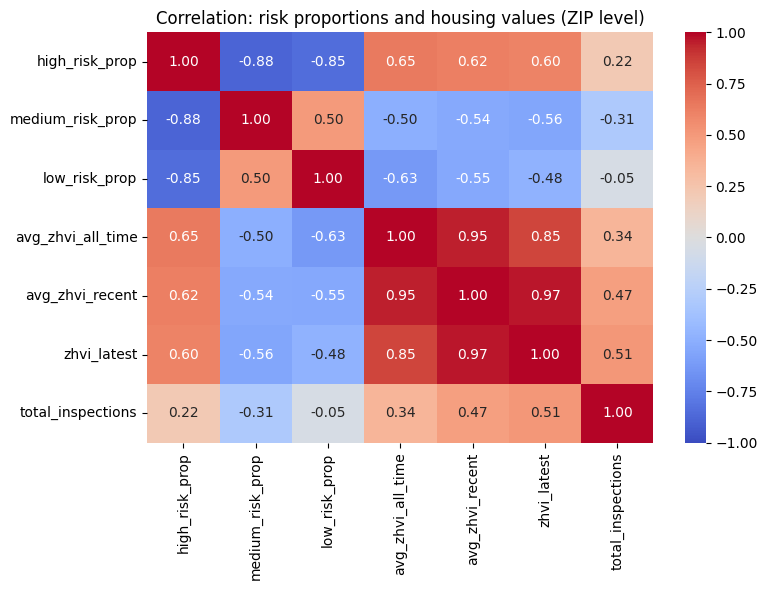

In [37]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation: risk proportions and housing values (ZIP level)")
plt.tight_layout()
plt.show()

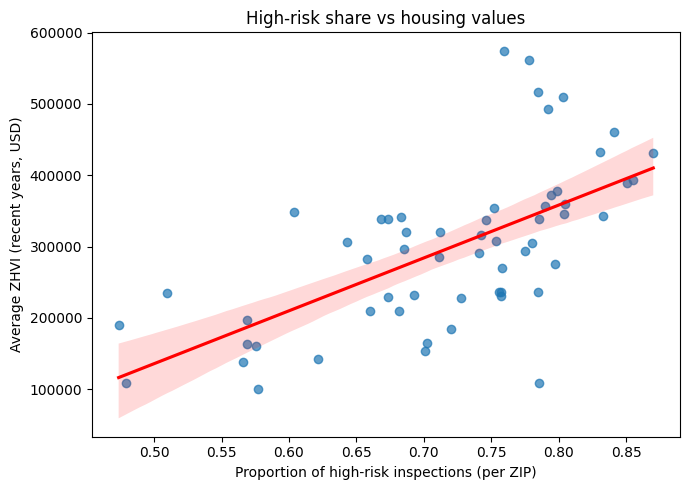

In [38]:
# 3.1 High-risk proportion vs recent ZHVI
plt.figure(figsize=(7, 5))
sns.regplot(
    data=zip_level,
    x="high_risk_prop",
    y="avg_zhvi_recent",
    scatter_kws={"alpha": 0.7},
    line_kws={"color": "red"}
)
plt.xlabel("Proportion of high-risk inspections (per ZIP)")
plt.ylabel("Average ZHVI (recent years, USD)")
plt.title("High-risk share vs housing values")
plt.tight_layout()
plt.show()

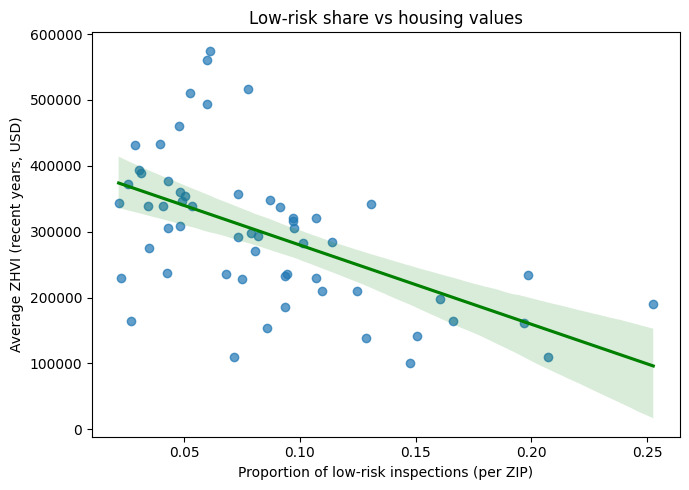

In [39]:
# 3.2 Low-risk proportion vs recent ZHVI
plt.figure(figsize=(7, 5))
sns.regplot(
    data=zip_level,
    x="low_risk_prop",
    y="avg_zhvi_recent",
    scatter_kws={"alpha": 0.7},
    line_kws={"color": "green"}
)
plt.xlabel("Proportion of low-risk inspections (per ZIP)")
plt.ylabel("Average ZHVI (recent years, USD)")
plt.title("Low-risk share vs housing values")
plt.tight_layout()
plt.show()

In [47]:
# 3.3 Correlation coefficients
r_high, p_high = pearsonr(zip_level["high_risk_prop"], zip_level["avg_zhvi_recent"])
r_low,  p_low  = pearsonr(zip_level["low_risk_prop"],  zip_level["avg_zhvi_recent"])
r_med,  p_med  = pearsonr(zip_level["medium_risk_prop"], zip_level["avg_zhvi_recent"])

print(f"High-risk prop vs avg_zhvi_recent:  r = {r_high:.3f}, p = {p_high:.3g}")
print(f"Medium-risk prop vs avg_zhvi_recent: r = {r_med:.3f}, p = {p_med:.3g}")
print(f"Low-risk prop vs avg_zhvi_recent:   r = {r_low:.3f},  p = {p_low:.3g}")

High-risk prop vs avg_zhvi_recent:  r = 0.624, p = 1.66e-07
Medium-risk prop vs avg_zhvi_recent: r = -0.536, p = 1.42e-05
Low-risk prop vs avg_zhvi_recent:   r = -0.546,  p = 9.37e-06


In [48]:
r_high_latest, p_high_latest = pearsonr(zip_level["high_risk_prop"], zip_level["zhvi_latest"])
r_low_latest,  p_low_latest  = pearsonr(zip_level["low_risk_prop"],  zip_level["zhvi_latest"])

print(f"High-risk prop vs zhvi_latest: r = {r_high_latest:.3f}, p = {p_high_latest:.3g}")
print(f"Low-risk  prop vs zhvi_latest: r = {r_low_latest:.3f},  p = {p_low_latest:.3g}")

High-risk prop vs zhvi_latest: r = 0.602, p = 5.7e-07
Low-risk  prop vs zhvi_latest: r = -0.480,  p = 0.000138


In [41]:
# 4.1 Tertiles by high- and low-risk proportions
zip_level["high_risk_tertile"] = pd.qcut(
    zip_level["high_risk_prop"],
    q=3,
    labels=["Low high-risk", "Medium high-risk", "High high-risk"]
)

zip_level["low_risk_tertile"] = pd.qcut(
    zip_level["low_risk_prop"],
    q=3,
    labels=["Low low-risk", "Medium low-risk", "High low-risk"]
)

zip_level["high_risk_tertile"].value_counts()

high_risk_tertile
Low high-risk       20
Medium high-risk    19
High high-risk      19
Name: count, dtype: int64

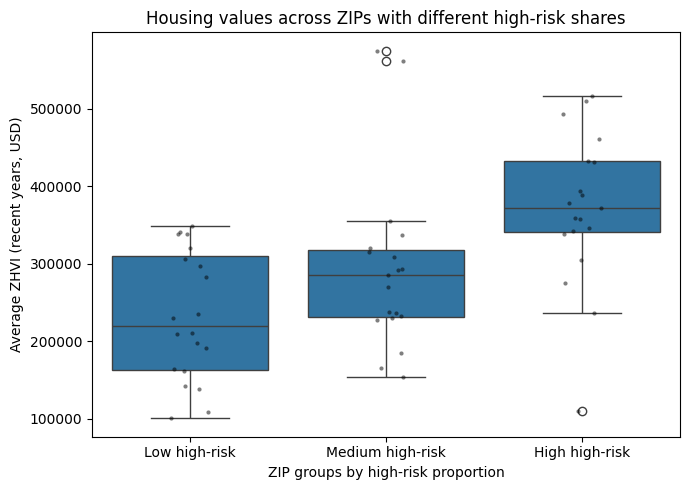

In [42]:
# 4.2 Boxplot: housing by high-risk tertiles
plt.figure(figsize=(7, 5))
order = ["Low high-risk", "Medium high-risk", "High high-risk"]
sns.boxplot(
    data=zip_level,
    x="high_risk_tertile",
    y="avg_zhvi_recent",
    order=order
)
sns.stripplot(
    data=zip_level,
    x="high_risk_tertile",
    y="avg_zhvi_recent",
    order=order,
    color="black",
    size=3,
    alpha=0.5
)
plt.xlabel("ZIP groups by high-risk proportion")
plt.ylabel("Average ZHVI (recent years, USD)")
plt.title("Housing values across ZIPs with different high-risk shares")
plt.tight_layout()
plt.show()

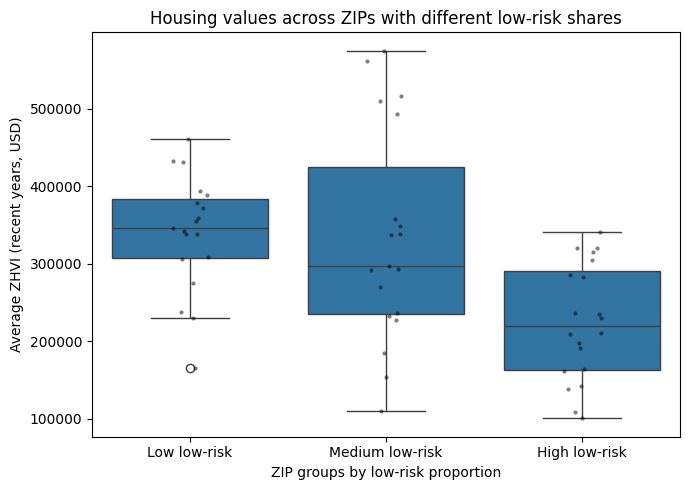

In [43]:
# 4.3 Boxplot: housing by low-risk tertiles
plt.figure(figsize=(7, 5))
order = ["Low low-risk", "Medium low-risk", "High low-risk"]
sns.boxplot(
    data=zip_level,
    x="low_risk_tertile",
    y="avg_zhvi_recent",
    order=order
)
sns.stripplot(
    data=zip_level,
    x="low_risk_tertile",
    y="avg_zhvi_recent",
    order=order,
    color="black",
    size=3,
    alpha=0.5
)
plt.xlabel("ZIP groups by low-risk proportion")
plt.ylabel("Average ZHVI (recent years, USD)")
plt.title("Housing values across ZIPs with different low-risk shares")
plt.tight_layout()
plt.show()

In [49]:
# Create quartiles of housing values
zip_level["zhvi_quartile"] = pd.qcut(
    zip_level["avg_zhvi_recent"],
    q=4,
    labels=["Q1 (lowest)", "Q2", "Q3", "Q4 (highest)"]
)

risk_by_price = (
    zip_level
    .groupby("zhvi_quartile")[["high_risk_prop", "low_risk_prop", "medium_risk_prop"]]
    .mean()
    .reindex(["Q1 (lowest)", "Q2", "Q3", "Q4 (highest)"])
)

print("Average risk proportions by housing price quartile:")
print(risk_by_price)

Average risk proportions by housing price quartile:
               high_risk_prop  low_risk_prop  medium_risk_prop
zhvi_quartile                                                 
Q1 (lowest)          0.627302       0.133105          0.239594
Q2                   0.718379       0.085092          0.196529
Q3                   0.722514       0.071339          0.206148
Q4 (highest)         0.806921       0.048639          0.144440


/var/folders/sh/z8h893ps7k92l_crm8fmjw800000gn/T/ipykernel_78222/604018513.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("zhvi_quartile")[["high_risk_prop", "low_risk_prop", "medium_risk_prop"]]


From these visuals, our analysis supports a clear story: Chicago ZIP codes with a higher share of “high‑risk” inspections tend to have higher home values, while those with more “low‑risk” inspections tend to have lower home values.

Correlation heatmap: 

- The heatmap shows positive correlations between all housing value measures (avg_zhvi_all_time, avg_zhvi_recent, zhvi_latest) and the high_risk_prop (around 0.6 to 0.65). 

- The same housing variables have negative correlations with low_risk_prop (around -0.48 to -0.63). 

- medium_risk_prop moves in the opposite direction of high_risk_prop (strongly negative correlation), which is expected because the three proportions sum to one.

- Interpretation: at the ZIP level, as the proportion of inspections classified as “Risk 1 (High)” increases, typical home values also increase; ZIPs with larger shares of “Risk 3 (Low)” inspections tend to have lower ZHVI values.

Scatterplots with regression lines: 

- The high‑risk scatterplot shows an upward‑sloping regression line: ZIPs with higher high_risk_prop concentrate toward higher avg_zhvi_recent.

- The low‑risk scatterplot shows a clear downward‑sloping regression line: ZIPs with higher low_risk_prop concentrate toward lower avg_zhvi_recent.

The Pearson results quantify this:

- High‑risk vs avg_zhvi_recent: r = 0.62, p = 1.7e-7
 
- These are strong positive correlations with very small p‑values, indicating that ZIP codes where a larger share of inspections are classified as “Risk 1 (High)” tend to have higher housing prices, both on average over recent years and in the most recent month.

- Low‑risk vs avg_zhvi_recent: r = -0.55, p = 9.4e-6

- These are clear negative correlations: ZIPs with higher proportions of “Risk 3 (Low)” inspections tend to have lower home values.


These are moderately strong, statistically significant associations, so they are unlikely to be due to random noise in this sample.

Boxplots by tertiles of risk proportions: 

- When ZIPs are grouped into tertiles by high_risk_prop, median housing values are lowest in the “Low high‑risk” group, higher in the “Medium high‑risk” group, and highest in the “High high‑risk” group.

- When grouped by low_risk_prop, the pattern reverses: ZIPs with “High low‑risk” shares show lower median ZHVI than those with “Low low‑risk” shares.

- Interpretation: the distributional view (not just the mean) is consistent with the scatterplots. ZIPs where inspections more often classify establishments as high‑risk tend to be more expensive housing markets; ZIPs with more low‑risk classifications tend to be cheaper.

How this answers our research goal: 
- Our research question was whether the proportion of “low‑risk” vs “high‑risk” establishments in a ZIP code correlates with local housing prices, and whether this relationship varies across neighborhoods.

From these results:

There is a clear correlation at the ZIP level:

Higher share of high‑risk inspections is associated with higher ZHVI.

Higher share of low‑risk inspections is associated with lower ZHVI.

This is the opposite of a naive expectation that “better food safety” (more low‑risk) would map onto higher property values. It suggests that in higher‑priced ZIPs, inspections are either stricter, restaurants are riskier in design/scale, or both, leading to more “Risk 1” classifications despite higher neighborhood affluence.

The strength and significance of the correlations show the pattern is systematic across ZIPs, not driven by one or two outliers.


Risk mix by housing price quartile: 

- In the lowest housing quartile (Q1), the mean high‑risk share is about 0.63, and mean low‑risk share is about 0.13.

- In the highest housing quartile (Q4), the mean high‑risk share rises to about 0.81, while the mean low‑risk share falls to about 0.05.

So moving from the cheapest to the most expensive ZIP codes, the typical share of inspections labeled high‑risk increases by roughly 18 percentage points, and the low‑risk share drops by about 8 percentage points. That pattern lines up with our boxplots: high‑price neighborhoods have both higher typical ZHVI and a risk profile that is more heavily weighted toward “Risk 1 (High)” and away from “Risk 3 (Low).”

To Summarize: 

At the ZIP level, there is a strong, statistically significant association between the mix of inspection risk categories and local housing prices. ZIPs with a higher proportion of inspections classified as “Risk 1 (High)” tend to have substantially higher ZHVI values, while those with more “Risk 3 (Low)” inspections tend to have lower ZHVI.

This pattern appears consistently across correlation coefficients, risk‑by‑price quartile summaries, scatterplots with regression lines, and boxplots comparing ZHVI distributions across risk tertiles.

The direction of the relationship is opposite to a naive expectation that “safer” restaurants (more low‑risk) would line up with more expensive housing; instead, higher‑priced ZIP codes show more inspections receiving high‑risk classifications. You can discuss possible mechanisms (stricter enforcement, denser or more complex food businesses, broader neighborhood factors) while emphasizing that the analysis is correlational, not causal.